In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
airline = pd.read_csv('international-airline-passengers.csv', names=['Month', 'Passengers'], header=0)

In [3]:
airline['Passengers'] = airline['Passengers'].fillna(airline['Passengers'].mean())

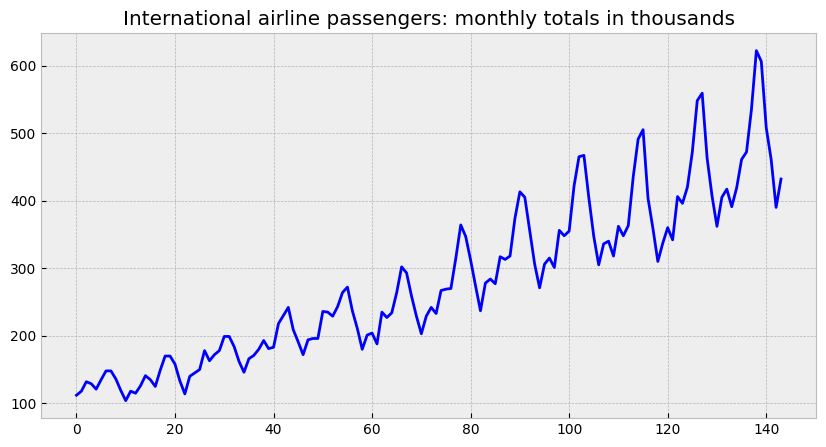

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 5))
    plt.title('International airline passengers: monthly totals in thousands')
    plt.plot(airline['Passengers'], color='blue')

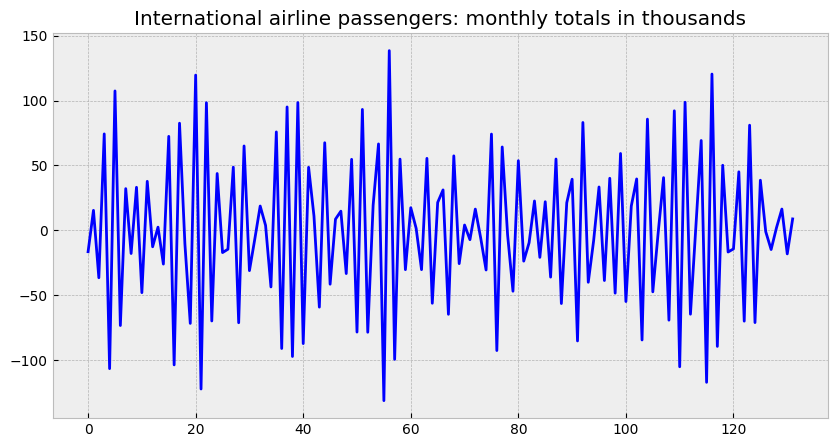

In [5]:
# Нормализация дисперсии + Дифференцируем
from scipy.stats import boxcox

series1 = pd.Series(boxcox(airline['Passengers'], 0))
series1 = pd.Series(np.diff(series1, 12))

with plt.style.context('bmh'):
    plt.figure(figsize=(10, 5))
    plt.title('International airline passengers: monthly totals in thousands')
    plt.plot(series1, color='blue')

In [6]:
# Проведем тест Тест Дики-Фуллера 
from statsmodels.tsa.stattools import adfuller

In [7]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

In [8]:
test_stationarity(series1)

Results of Dickey-Fuller Test:


Test Statistic                -1.606060e+01
p-value                        5.644461e-29
#Lags Used                     1.300000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64

### Приблизим оба варианта моделями из класса MA

In [9]:
def initial_trend(series, season_len):
    summa = 0.0
    for i in range(season_len):
        summa += float(series[i+season_len] - series[i]) / season_len
    return summa / season_len

In [10]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [11]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [12]:
def plot_tema(alpha, beta, gamma, ser=airline['Passengers'], ser_to_plot=airline['Passengers'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 5))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

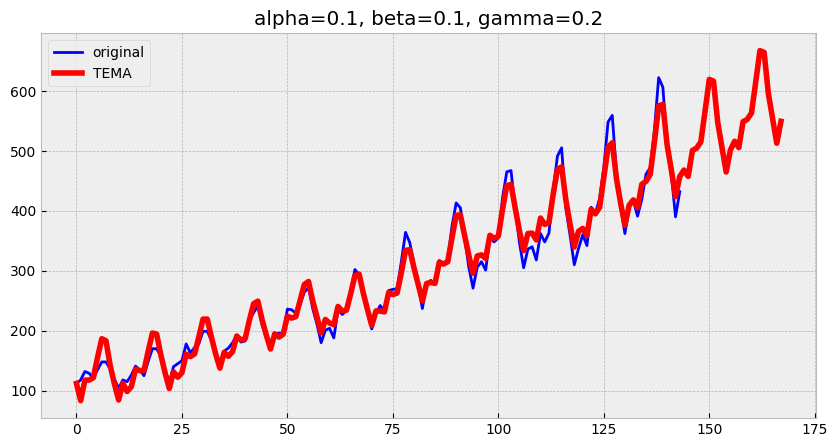

In [13]:
plot_tema(0.1, 0.1, 0.2)

In [14]:
# Используем RMSE для минимазции функции ошибки
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

series0 = airline['Passengers']
series1 = series1

print(f'80% для трэйна series0: {series0.shape[0]*0.8:.0f}\n80% для трэйна series1: {series1.shape[0]*0.8:.0f}')

80% для трэйна series0: 115
80% для трэйна series1: 106


In [15]:
# Зададим тест и трэйн
train0, test0 = series0[:116], series0[116:]
train1, test1 = series1[:107], series1[107:]

In [16]:
def mse0(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train0, 12, alpha, beta, gamma, len(test0))
    predictions = result[-len(test0):]
    error = mean_squared_error(predictions, test0)
    return error

def mse1(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train1, 12, alpha, beta, gamma, len(test1))
    predictions = result[-len(test1):]
    error = mean_squared_error(predictions, test1)
    return error

In [17]:
opt0 = minimize(mse0, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
opt1 = minimize(mse1, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_0, beta_0, gamma_0 = opt0.x
alpha_1, beta_1, gamma_1 = opt1.x

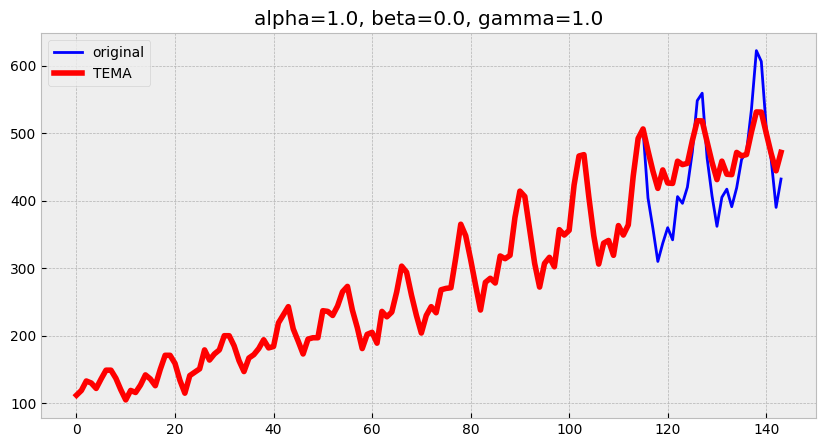

In [18]:
plot_tema(alpha_0, beta_0, gamma_0, ser=train0, ser_to_plot=series0, n_preds=len(test0))

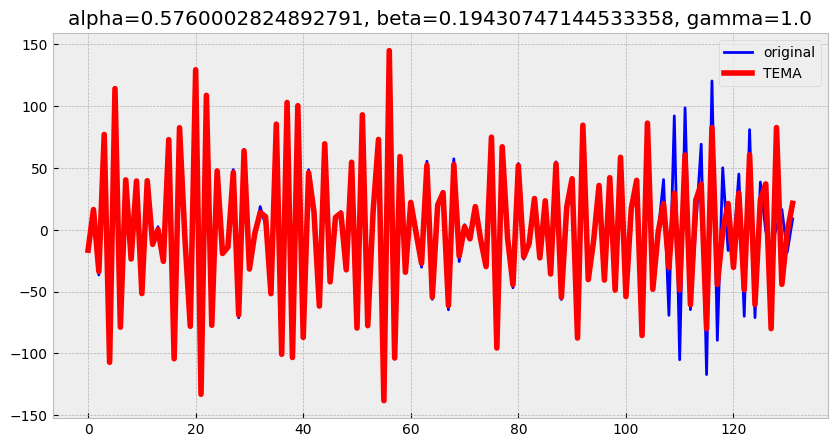

In [19]:
plot_tema(alpha_1, beta_1, gamma_1, ser=train1, ser_to_plot=series1, n_preds=len(test1))

### Исаользовалось тройное экспоненциальное сглаживание Хольта-Винтерса и подбор параметров через RMSE, так как у нас в ряде имеется и тренд и сезонность. 
#### При подобранных параметрах альфы, бетты и гаммы через RMSE:
- НЕ стационарный ряд -> Реальные данные полностью дублируется нашей моделью, но вот предсказание так себе. Тренд сохраняется не очень, а сезонность хоть и просматривается, но не совпадает с реальностью (скрытой частью).
- Стационарный ряд -> Реальные данные почти полностью дублируется нашей моделью, но предсказание уже лучше. Тренда и сезонности нет и данные неплохо совпадают с реальностью (скрытой частью).